<a href="https://colab.research.google.com/github/Hz2314/Learning_Pytorch/blob/PyTorch_Tutorial_1/Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#⚡TUTORIAL 2: ACTIVATION FUNCTIONS⚡

이 튜토리얼에서는 (인기 있는) 활성화 기능을 자세히 살펴보고 신경망의 최적화 속성에 미치는 영향을 조사할 것입니다. 활성화 기능은 신경망에 비선형성을 추가하기 때문에 딥 러닝 모델의 중요한 부분입니다. 문헌에는 매우 다양한 활성화 기능이 있으며, 일부는 다른 기능보다 더 유익합니다. 이 튜토리얼의 목적은 올바른 활성화 기능을 선택하는 것의 중요성(및 선택 방법)과 그렇지 않을 경우 발생할 수 있는 문제를 보여주는 것입니다. 이 노트는 암스테르담 대학의 딥 러닝 강의 시리즈의 일부입니다. 튜토리얼의 전체 목록은 https://uvadlc-notebooks.rtfd.io 에서 확인할 수 있습니다.

ctrl m d  셀 삭제


#Setup

이 노트북은 파이토치 라이트닝 외에도 몇 가지 패키지가 필요합니다.





In [73]:
! pip install --quiet "matplotlib" "torchvision" "torchmetrics>=0.7, <0.12" "setuptools==67.4.0" "seaborn" "lightning>=2.0.0rc0" "pytorch-lightning>=1.4, <2.0.0" "torch>=1.8.1, <1.14.0" "ipython[notebook]>=8.0.0, <8.12.0"

시작하기 전에 표준 라이브러리를 가져오고 기본 기능을 설정합니다:

In [74]:
import json
import math
import os
import urllib.request
import warnings
from urllib.error import HTTPError

import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("svg","pdf") #내보내기 위함
sns.set()

우리는 이 튜토리얼에서 numpy와 torch와 같은 모든 라이브러리에 대해 시드를 설정하는 함수를 정의할 것입니다. 이를 통해 우리는 학습을 재현할 수 있습니다. 그러나 CPU와 달리 다른 GPU 아키텍처에서 동일한 시드는 다른 결과를 줄 수 있습니다. 여기서 모든 모델은 NVIDIA GTX1080Ti에서 학습되었습니다.

또한 다음 셀에서는 두 개의 경로를 정의합니다: DATASET_PATH 및 CHECKPOINT_PATH입니다. 데이터 세트 경로는 노트북에서 사용하는 데이터 세트를 다운로드 할 디렉토리입니다. PyTorch의 모든 데이터 세트를 하나의 결합된 디렉토리에 저장하는 것이 좋습니다. 중복 다운로드를 방지하기 위해입니다. 체크포인트 경로는 학습된 모델 가중치 및 추가 파일을 저장할 디렉토리입니다. 필요한 파일은 자동으로 다운로드됩니다. Google Colab에 있는 경우, 현재 디렉토리에서 시작하도록 디렉토리를 변경하는 것이 좋습니다 (즉, 데이터 세트 및 체크포인트 경로에서 …/를 제거하십시오).

In [75]:
# 데이터 세트를 다운로드해야 하는 폴더의 경로(예: MNIST)
DATASET_PATH = os.environ.get("PATH_DATASETS","data/")
# 사전 교육된 모델이 저장된 폴더의 경로
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT","saved_models/Activation_Functions/")

# 시드 설정 함수 정의
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available(): # GPU 작업에는 별도의 시드가 있습니다
     torch.cuda.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)

set_seed(42)

# 또한 GPU의 일부 작업은 효율성을 위해 확률적으로 구현됩니다
# 재현성을 위해 GPU(사용되는 경우)에서 모든 작업이 결정론적임을 보장하고자 합니다
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 이 노트북 전체에서 사용할 장치를 가져오는 중
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device) # 런타임



Using device cuda:0


다음 셀은 이 노트북에서 사용할 모든 사전 교육된 모델을 다운로드합니다. 파일은 노트북 저장소의 크기를 줄이기 위해 별도의 저장소에 저장되며, 특히 ReadTheDocs에서 문서를 작성하기 위해 저장됩니다. 아래 다운로드가 실패할 경우 Google Drive 폴더에서 모델을 다운로드할 수 있습니다. 오류가 발생하면 모든 학생이 해결할 수 있도록 (필립) 알려주시기 바랍니다.

In [76]:
# 이 튜토리얼에 대해 저장된 모델이 저장되는 Github URL
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# 다운로드할 파일
pretrained_files = [
    "FashionMNIST_elu.config",
    "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config",
    "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNiST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config",
    "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar",
]
# 체크포인트 경로가 아직 없는 경우 생성
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# 각 파일에 대해 파일이 이미 있는지 확인합니다. 그렇지 않은 경우 다운로드
for file_name in pretrained_files:
  file_path = os.path.join(CHECKPOINT_PATH, file_name)
  if not os.path.isfile(file_path):
    file_url = base_url + file_name
    print(f"Downloading {file_url}...")
    try:
      urllib.request.urlretrieve(file_url, file_path)
    except HTTPError as e:
      print(
          "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",e,
      )


Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:
 HTTP Error 404: Not Found


#공통 활성화 기능
첫 번째 단계로 몇 가지 일반적인 활성화 기능을 직접 구현합니다. 물론 대부분은 torch.nn 패키지에서도 찾을 수 있습니다(개요는 설명서 참조). 하지만, 우리는 더 나은 이해와 통찰력을 위해 여기에 우리만의 기능을 쓸 것입니다.

다양한 활성화 기능을 보다 쉽게 비교할 수 있도록 향후 모든 모듈이 상속될 기본 클래스를 정의하는 것으로 시작합니다:

In [77]:
class ActivationFunction(nn.Module):
  def __init__(self):
    super().__init__()
    self.name = self.__class__.__name__
    self.config = {"name":self.name}

활성화 함수는 모두 nn.Module이어야 하므로 네트워크에 적절하게 통합할 수 있습니다. 일부 활성화 함수에 대한 조정 가능한 매개변수를 저장하기 위해 구성 딕셔너리를 사용합니다.

다음으로, 여러 작업에 여전히 널리 사용되는 “가장 오래된” 활성화 함수 중 두 개를 구현합니다 : 시그모이드 및 tanh. 시그모이드 및 tanh 활성화는 PyTorch 함수 (torch.sigmoid, torch.tanh) 또는 모듈 (nn.Sigmoid, nn.Tanh)로도 찾을 수 있습니다. 여기서 우리는 그것들을 직접 구현합니다.

In [78]:
class Sigmoid(ActivationFunction):
  def forward(self, x):
    return 1/(1 + torch.exp(-x))

class Tanh(ActivationFunction):
  def forward(self, x):
    x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
    return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

ReLU는 단순한 조각선형 함수이지만 sigmoid와 tanh와 비교하여 큰 범위의 값에 대해 강하고 안정적인 기울기를 가지는 장점이 있습니다. 이 아이디어를 기반으로 ReLU의 여러 변형이 제안되었으며, 이 중 LeakyReLU, ELU 및 Swish를 구현할 것입니다. LeakyReLU는 입력의 이러한 부분에서도 기울기가 흐를 수 있도록 음수 부분의 제로 설정을 더 작은 기울기로 대체합니다. 비슷하게, ELU는 음수 부분을 지수적 감쇠로 대체합니다. 세 번째로 최근에 제안된 활성화 함수는 Swish입니다. 이것은 실제로 "최적" 활성화 함수를 찾기 위한 대규모 실험의 결과입니다. 다른 활성화 함수와 비교하여 Swish는 매끄럽고 단조적이지 않습니다(즉, 기울기의 부호가 바뀝니다). 이것은 표준 ReLU 활성화와 마찬가지로 깊은 네트워크에서 죽은 뉴런을 방지하는 것으로 나타났습니다. 관심이 있다면, Swish의 이점에 대한 더 자세한 논의는 이 논문에서 찾을 수 있습니다 .

아래 네 가지 활성화 함수를 구현해보세요:
- ReLU
- LeakyReLU
- ELU
- Swish

: https://arxiv.org/abs/1710.05941

In [79]:
# 코드 실행이 안 되면 오타 확인하기

class ReLU(ActivationFunction):
  def forward(self, x):
    return x*(x>0).float()

class LeakyReLU(ActivationFunction):
  def __init__(self, alpha=0.1):
    super().__init__()
    self.config["alpha"]= alpha

  def forward(self, x):
    return torch.where(x>0, x, self.config["alpha"]*x)


class ELU(ActivationFunction):
  def forward(self,x):
    return torch.where(x>0, x, torch.exp(x) - 1)


class Swish(ActivationFunction):
  def forward(self, x):
    return x * torch.sigmoid(x)

나중에 사용하기 위해 모든 활성화 기능을 이름과 클래스 객체를 매핑한 딕셔너리로 요약합니다. 직접 새로운 활성화 기능을 구현하면 이곳에 추가하여 나중에 비교할 때 포함시킵니다.

In [80]:
act_fn_by_name = {"sigmoid": Sigmoid, "tanh":Tanh, "relu": ReLU, "leakyrelu":LeakyReLU, "elu":ELU, "swish": Swish}

#Visualizing activation functions (활성화 기능 시각화)

각 활성화 함수가 실제로 무엇을 하는지 이해하기 위해 다음에서 시각화합니다. 실제 활성화 값 옆에 함수의 기울기는 신경망을 최적화하는 데 중요한 측면입니다. PyTorch는 backward (역전파) 함수를 호출하여 기울기를 계산할 수 있습니다.

In [81]:
def get_grads(act_fn, x):
    """지정된 위치에서 활성화 함수의 기울기를 계산합니다.

    인수:
        act_fn: "활성화" 클래스의 개체입니다Function"은 전진 패스가 구현된 것입니다.
        x: 1D 입력 텐서.
    반환:
        x에서 act_fn의 기울기를 포함하는 x의 크기가 같은 텐서.
    """
    x = x.clone().requires_grad_() # 그라데이션을 저장할 텐서로 입력 표시
    out = act_fn(x)
    out.sum().backward() # 합하면 x의 각 원소에 대한 동일한 구배 흐름이 생성됩니다
    return x.grad # "x.grad"에 의한 x의 기울기 액세스

    #이제 기울기를 포함한 모든 활성화 기능을 시각화할 수 있습니다:

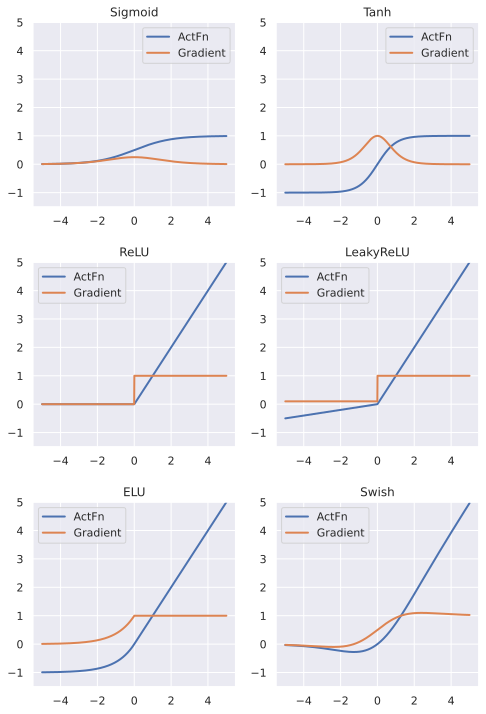

In [82]:
def vis_act_fn(act_fn, ax, x):
  # 활성화 기능 실행
  y = act_fn(x)
  y_grads = get_grads(act_fn, x)

  # x, y 및 그라데이션을 CPU로 다시 밀어 표시합니다
  x,y,y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()

  # 플롯
  ax.plot(x, y, linewidth=2, label="ActFn")
  ax.plot(x, y_grads, linewidth=2, label="Gradient")
  ax.set_title(act_fn.name)
  ax.legend()
  ax.set_ylim(-1.5, x.max())

# 원하는 경우 활성화 기능 추가
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)  # 활성화 기능을 시각화할 범위

#plotting
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i, act_fn in enumerate(act_fns):
  vis_act_fn(act_fn, ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()
#enumerate(열거하다)
#   이 함수는 순서가 있는 자료형(리스트, 튜플, 문자열)을 입력받아 인덱스값에 포함시키는 역할
#  쉽게 말하자면 리스트, 튜플, 문자열에 순서를 넣는다고 생각하면 됩니다.

#  대부분 순서를 내야하기 때문에 반복문for문과 같이 쓰입니다.
# (값 한개당 1번의 반복을 해야하므로)

#Analysing the effect of activation functions(활성화 기능의 효과 분석)

활성화 기능을 구현하고 시각화한 후, 우리는 그 효과에 대한 통찰력을 얻는 것을 목표로 합니다. 우리는 FashionMNIST에서 훈련된 간단한 신경망을 사용하여 이를 수행하고 성능 및 기울기 흐름을 포함하여 모델의 다양한 측면을 조사합니다.

#Setup

먼저, 신경망을 설정해 보겠습니다. 선택한 네트워크는 이미지를 1D 텐서로 보고 일련의 선형 레이어와 지정된 활성화 기능을 통해 이미지를 푸시합니다. 다른 네트워크 아키텍처를 자유롭게 사용해 보십시오.

In [83]:
class BaseNetwork(nn.Module):
  def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
   """
   인수:
      act_fn: 네트워크에서 비선형성으로 사용해야 하는 활성화 함수의 개체입니다.
      input_size: 입력 이미지의 크기(픽셀)
      num_dll: 예측할 클래스 수
      hidden_size: NN의 숨겨진 레이어 크기를 지정하는 정수 목록
   """
   super().__init__()
   # 지정된 숨겨진 크기를 기준으로 네트워크 생성
   layers = []
   layer_sizes = [input_size] + hidden_sizes
   layer_size_last =layer_sizes[0]
   for layer_size in layer_sizes[1:]:
      layers += [nn.Linear(layer_size_last, layer_size), act_fn]
      layer_size_last = layer_size
   layers += [nn.Linear(layer_sizes[-1], num_classes)]
    # nn.Sequential은 모듈 목록을 하나의 모듈로 요약하여 순차적으로 적용합니다
   self.layers = nn.Sequential(*layers)

   # 모델의 저장 및 로드를 위해 모든 하이퍼 파라미터를 사전에 저장합니다
   self.config = {
      "act_fn": act_fn.config,
      "input_size": input_size,
      "num_classes": num_classes,
      "hidden_sizes": hidden_sizes,
      }

  def forward(self, x):
    x = x.view(x.size(0), -1) # 이미지 모양을 평평한 벡터로 변경
    out = self.layers(x)
    return out


우리는 또한 모델을 로드하고 저장하는 기능을 추가합니다. 하이퍼 파라미터는 구성 파일(단순 json 파일)에 저장됩니다:

In [84]:
def _get_config_file(model_path, model_name):
  # 하이퍼파라미터 세부 정보를 저장하기 위한 파일 이름
  return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
  # 네트워크 매개 변수를 저장하기 위한 파일 이름
  return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
  """디스크에서 저장된 모델을 로드합니다.

  인수:
      model_path: 체크포인트 디렉터리의 경로
      model_name: 모델 이름(str)
       net: (선택 사항) 지정된 경우 상태 dict가 이 모델에 로드됩니다. 그렇지 않으면 새 모델이 생성됩니다.
  """
  config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
  assert os.path.isfile(config_file), f'Could not find the config file "{config_file}". Are you sure this is the correct path and you have your model config stored here?'
  assert os.path.isfile(model_file), f'Could not find the config file "{model_file}". Are you sure this is the correct path and you have your model config stored here?'
  with open(config_file) as f:
    config_dict = json.load(f)
  if net is None:
    act_fn_name = config_dict["act_fn"].pop("name").lower()
    act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
    net  = BaseNetwork(act_fn=act_fn, **config_dict)
  net.load_state_dict(torch.load(model_file, map_location=device))
  return net

def save_model(model, model_path, model_name):
  """모델이 주어지면 state_dict와 하이퍼 파라미터를 저장합니다.

  인수:
      모형: 매개 변수를 저장할 네트워크 개체
      model_path: 체크포인트 디렉터리의 경로
      model_name: 모델 이름(str)
  """
  config_dict = model.config
  os.makedirs(model_path, exist_ok=True)
  config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
  with open(config_file, "w") as f:
    json.dump(config_dict, f)
  torch.save(model.state_dict(), model_file)

또한 우리는 훈련시킬 데이터 세트, 즉 FashionMNIST를 설정합니다. 패션MNIST는 MNIST의 더 복잡한 버전이며 숫자 대신 흑백의 옷 이미지를 포함합니다. 10개의 클래스에는 바지, 코트, 신발, 가방 등이 포함됩니다. 이 데이터 세트를 로드하기 위해 또 다른 PyTorch 패키지, 즉 토치비전(문서)을 사용할 것입니다. 토치비전 패키지는 널리 사용되는 데이터 세트, 모델 아키텍처 및 컴퓨터 비전을 위한 공통 이미지 변환으로 구성됩니다. 이 과정의 많은 노트북에 패키지를 사용하여 데이터 세트 처리를 간소화할 것입니다.

아래 데이터 세트를 로드하고 데이터에 대한 인상을 얻기 위해 몇 가지 이미지를 시각화해 보겠습니다.

In [85]:
# 각 이미지에 적용된 변환 => 먼저 텐서로 만든 다음 -1~1 범위에서 정규화합니다
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

# training 데이터 세트를 로드하는 중입니다. training 및 검증 부분으로 분할해야 합니다
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset,[50000, 10000])

# 테스트 세트 로드
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

나중에 다양한 용도로 사용할 수 있는 데이터 로더 세트를 정의합니다. 모델을 실제로 교육하기 위해 배치 크기가 더 작은 다른 데이터 로더를 사용합니다.

In [86]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

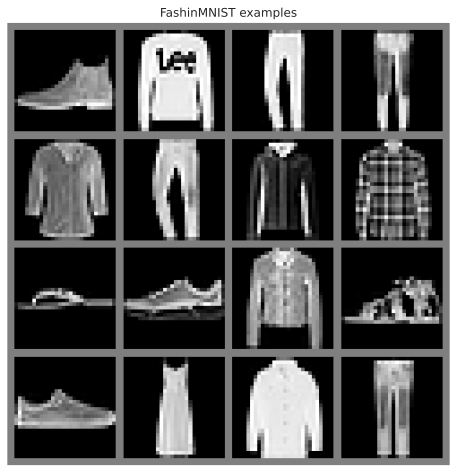

In [87]:
exmp_imgs = [test_set[i][0] for i in range(16)]

# 이미지를 그리드로 구성하여 시각화 개선
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt. title("FashinMNIST examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


#Visualizing the gradient flow after initialization (초기화 후 그라데이션 흐름 시각화)

앞서 언급했듯이 활성화 기능의 한 가지 중요한 측면은 네트워크를 통해 그레이디언트를 전파하는 방법입니다. 우리가 50개 이상의 층으로 이루어진 매우 깊은 신경망을 가지고 있다고 상상해 보세요. 입력 레이어, 즉 첫 번째 레이어에 대한 그레이디언트는 활성화 함수의 50배 이상을 통과했지만 여전히 적절한 크기를 원합니다. 활성화 함수를 통한 기울기가 (예상치로) 1보다 상당히 작으면 입력 계층에 도달할 때까지 기울기가 사라집니다. 활성화 기능을 통한 기울기가 1보다 크면 기울기가 기하급수적으로 증가하여 폭발할 수 있습니다.

모든 활성화 기능이 그라데이션에 어떤 영향을 미치는지 알아보기 위해 새로 초기화된 네트워크를 살펴보고 256개 이미지 배치에 대해 각 파라미터의 그라데이션을 측정할 수 있습니다:

In [88]:
def visualize_gradients(net, color="C0"):
  """
  인수:
  net: 클래스 기본 네트워크의 개체
  색상: 히스토그램을 시각화할 색상(활성화 기능을 쉽게 분리할 수 있도록)
  """
  net.eval()
  small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
  imgs, labels = next(iter(small_loader))
  imgs, labels = imgs.to(device), labels.to(device)

  # 네트워크를 통해 한 batch를 전달하고 가중치에 대한 기울기를 계산합니다
  net.zero_grad()
  preds = net(imgs)
  loss = F.cross_entropy(preds, labels)
  loss.backward()
  # 시각화를 가중치 매개변수로 제한하고 편향을 제외하여 플롯의 수를 줄입니다
  grads = {
      name: params.grad.data.view(-1).cpu().clone().numpy()
      for name, params in net.named_parameters()
      if "weight" in name
  }
  net.zero_grad()

  #plotting
  columns = len(grads)
  fig, ax = plt.subplots(1, columns, figsize=(columns *3.5, 2.5 ))
  fig_index = 0
  for key in grads:
    key_ax = ax[fig_index % columns]
    sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
    key_ax.set_title(str(key))
    key_ax.set_xlabel("Grad magnitude")
    fig_index += 1
  fig.suptitle(
        f"Gradient magnitude distribution for activation function{net.config['act_fn']['name']}", fontsize=14, y=1.05
    )
  fig.subplots_adjust(wspace=0.45)
  plt.show()
  plt.close()

  #인덴트 조심

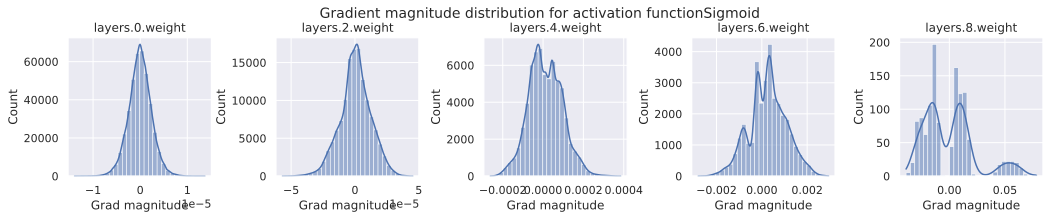

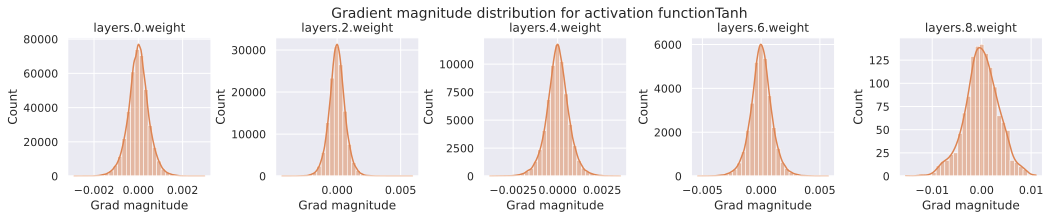

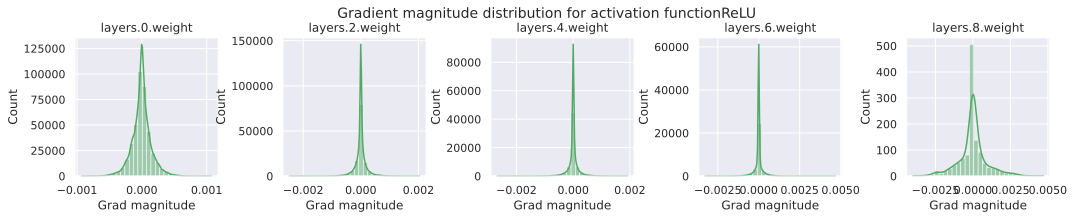

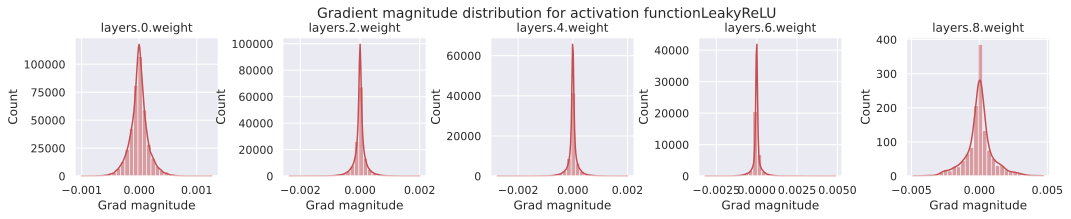

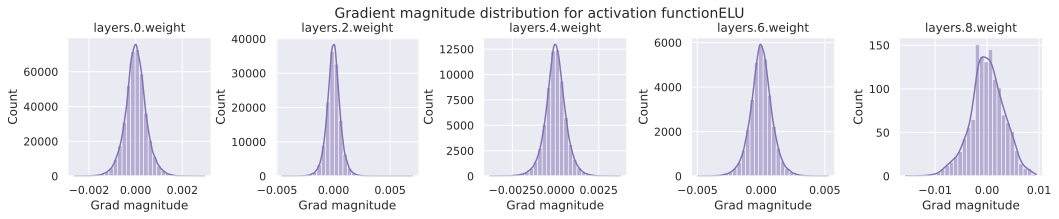

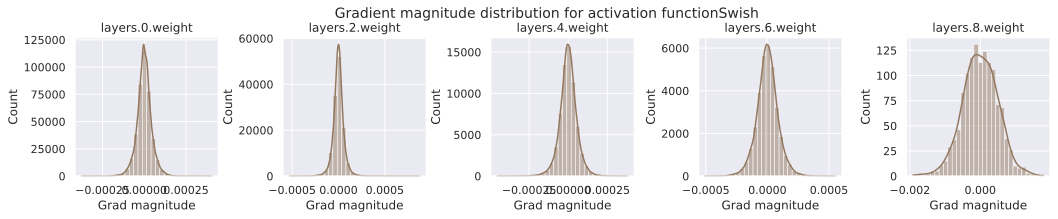

In [89]:
# Seaborn은 히스토그램의 값이 작을 경우 경고를 인쇄합니다. 우리는 지금 그들을 무시할 수 있습니다
warnings.filterwarnings("ignore")
# 모든 활성화 함수에 대한 플롯 생성
for i, act_fn_name in enumerate(act_fn_by_name):
  # 시드를 설정하면 각 활성화 기능에 대해 동일한 가중치 초기화가 가능합니다
  set_seed(42)
  act_fn = act_fn_by_name[act_fn_name]()
  net_actfn = BaseNetwork(act_fn=act_fn).to(device)
  visualize_gradients(net_actfn, color=f"C{i}")

시그모이드 활성화 기능은 분명히 바람직하지 않은 행동을 보여줍니다. 출력 계층의 기울기는 최대 0.1로 매우 크지만 입력 계층은 1e-5만으로 모든 활성화 기능에서 가장 낮은 기울기 표준을 가집니다. 이는 최대 기울기가 1/4로 작기 때문이며, 이 설정에서는 모든 계층에서 적절한 학습 속도를 찾는 것이 불가능합니다. 다른 모든 활성화 함수는 모든 계층에 걸쳐 유사한 기울기 규범을 갖는 것을 보여줍니다. 흥미롭게도, ReLU 활성화는 왼쪽의 0 부분에 의해 발생하는 0 주변의 스파이크와 죽은 뉴런(이에 대해 나중에 자세히 알아보겠습니다)을 가지고 있습니다.

활성화 외에도 가중치 파라미터의 초기화가 중요할 수 있습니다. 기본적으로 PyTorch는 Tanh 활성화에 최적화된 선형 레이어에 Kaiming 초기화를 사용합니다. 튜토리얼 4에서는 초기화에 대해 자세히 살펴보겠지만, 지금은 Kaiming 초기화가 모든 활성화 기능에 대해 상당히 잘 작동한다고 가정합니다.

#Training a model (모델 교육)
다음으로, 우리는 FashionMNIST에서 다양한 활성화 기능으로 모델을 훈련시키고 얻은 성능을 비교하고자 합니다. 전반적으로, 우리의 최종 목표는 우리가 선택한 데이터 세트에서 가능한 최고의 성능을 달성하는 것입니다. 따라서, 우리는 매 에포지션 이후의 검증과 최상의 모델에 대한 최종 테스트를 포함하여 다음 셀에 훈련 루프를 작성합니다:

In [90]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """Train a model on the training set of FashionMNIST.

    Args:
        net: Object of BaseNetwork
        model_name: (str) Name of the model, used for creating the checkpoint names
        max_epochs: Number of epochs we want to (maximally) train for
        patience: If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size: Size of batches used in training
        overwrite: Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)  # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0.0, 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)  # To GPU
                optimizer.zero_grad()  # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(
                f"[Epoch {epoch+1:2i}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
            )

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=") + "\n")
    return test_acc


def test_model(net, data_loader):
    """Test a model on a specified dataset.

    Args:
        net: Trained model of type BaseNetwork
        data_loader: DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

각 활성화 기능에 대해 하나의 모델을 교육합니다.
CPU에서 이 노트북을 실행하는 경우 시간을 절약하기 위해 사전 교육을 받은 모델을 사용하는 것이 좋습니다.

In [93]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...


AssertionError: ignored

놀랍지 않게도, 시그모이드 활성화 함수를 사용하는 모델은 실패를 보이고 무작위 성능(랜덤 찬스의 경우 10개 클래스 => 1/10)에서 개선되지 않습니다.

다른 모든 활성화 기능은 유사한 성능을 얻습니다. 보다 정확한 결론을 얻기 위해서는 여러 시드에 대한 모델을 교육하고 평균을 살펴봐야 합니다. 그러나 "최적" 활성화 기능은 또한 많은 다른 요인(숨겨진 크기, 레이어 수, 레이어 유형, 작업, 데이터 세트, 최적화 도구, 학습 속도 등)에 따라 달라지므로 철저한 그리드 검색은 우리의 경우 유용하지 않을 것입니다. 문헌에서, 심층 네트워크에서 잘 작동하는 것으로 나타난 활성화 기능은 우리가 여기서 실험하는 모든 유형의 ReLU 함수이며, 특정 네트워크의 특정 활성화 기능에 대한 작은 이득이 있습니다.

# Visualizing the activation distribution 활성화 분포 시각화
모델을 교육한 후에는 모델 내부에서 발견되는 실제 활성화 값을 살펴볼 수 있습니다. 예를 들어 ReLU에서 0으로 설정된 뉴런의 수는 얼마나 됩니까? 탄에서 가장 많은 가치를 찾을 수 있는 곳은 어디입니까? 이러한 질문에 답하기 위해 훈련된 모델을 가져와서 이미지 배치에 적용하고 네트워크 내부의 활성화 히스토그램을 표시하는 간단한 함수를 작성할 수 있습니다: